**This file is the initial day one exploration using Linear Regression - some of the ideas here are not completely realized or up to date. Refer to later versions of exploration.**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

In [2]:
scene_df = pd.read_hdf('dataset/scene.hdf5')
calibration_df = pd.read_hdf('dataset/calibration_set_1.hdf5')

#### Temporal averaging

In [3]:
# Calculate the average calibration image
calibration_images = np.stack(calibration_df['image'].values)
calibration_average = np.mean(calibration_images, axis=0)

# Apply temporal averaging to each scene image
scene_images = np.stack(scene_df['image'].values)
denoised_images = scene_images - calibration_average

In [4]:
# Create a new DataFrame to hold denoised images and other data
denoised_scene_df = scene_df.copy()
denoised_scene_df['denoised_image'] = list(denoised_images)

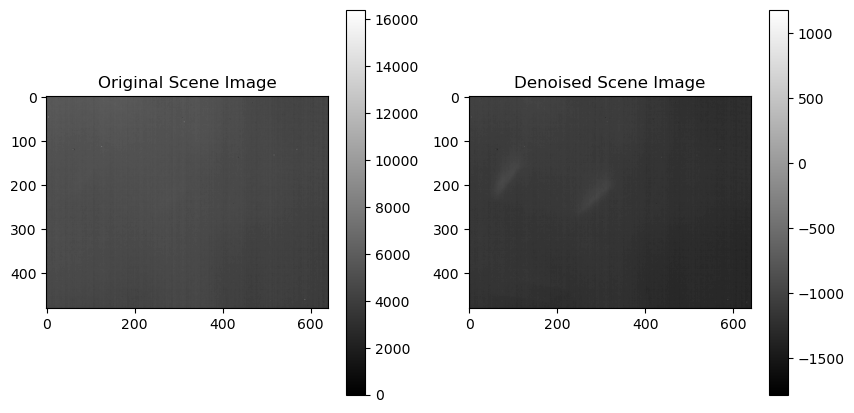

In [5]:
# Display original and denoised images for comparison
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_df['image'][index], cmap='gray')
plt.colorbar()

# Denoised scene image
plt.subplot(1, 2, 2)
plt.title("Denoised Scene Image")
plt.imshow(denoised_scene_df['denoised_image'][index], cmap='gray')
plt.colorbar()

plt.show()

#### Other filtering techniques: non-local means, median filter 

In [6]:
from scipy.ndimage import median_filter

def apply_median_filter(image, size=3):
    return median_filter(image, size=size)

def non_local_means_denoise(image, h=10, templateWindowSize=7, searchWindowSize=21):
    return cv2.fastNlMeansDenoising(np.uint8(image), h=h, templateWindowSize=templateWindowSize, searchWindowSize=searchWindowSize)

# Combine median filtering and NLM denoising
denoised_combined_images = np.array([non_local_means_denoise(apply_median_filter(img)) for img in denoised_images])


In [7]:
denoised_scene_df['denoised_image_nlm'] = list(denoised_combined_images)

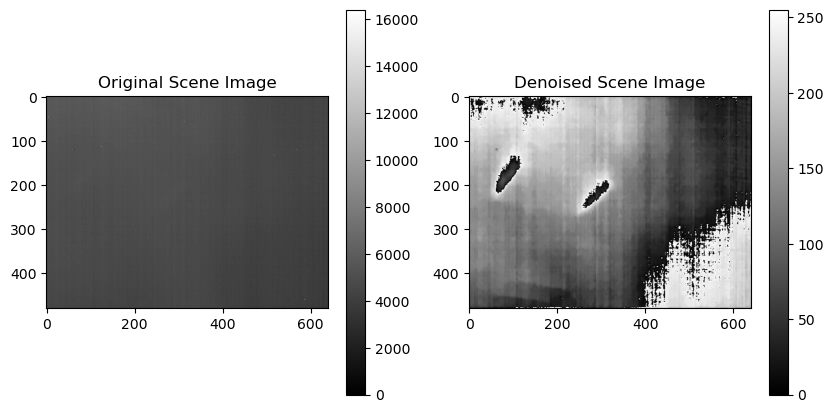

In [8]:
# Display original and denoised images for comparison
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_df['image'][index], cmap='gray')
plt.colorbar()

# Denoised scene image
plt.subplot(1, 2, 2)
plt.title("Denoised Scene Image")
plt.imshow(denoised_scene_df['denoised_image_nlm'][index], cmap='gray')
plt.colorbar()

plt.show()

#### Calculating Gain and Offset for pixels

In [9]:
# Extract calibration images and their corresponding temperatures
calibration_images = np.stack(calibration_df['image'].values)
temperatures = calibration_df['t_fpa'].values  # Example: FPA temperature in degrees Celsius

# Assume we have two distinct temperatures
T1_images = calibration_images[temperatures == temperatures.min()]
T2_images = calibration_images[temperatures == temperatures.max()]

# Calculate the average calibration image at each temperature
avg_T1_image = np.mean(T1_images, axis=0)
avg_T2_image = np.mean(T2_images, axis=0)

# Calculate gain and offset for each pixel
gain = (avg_T2_image - avg_T1_image) / (temperatures.max() - temperatures.min())
offset = avg_T1_image - gain * temperatures.min()

In [10]:
# Function to apply gain and offset correction
def apply_gain_offset_correction(image, gain, offset):
    return (image - offset) / gain

# Apply the correction to each scene image
scene_images = np.stack(scene_df['image'].values)
corrected_scene_images = np.array([apply_gain_offset_correction(img, gain, offset) for img in scene_images])

/var/folders/54/hy0k25rj3qq6wl3dn1jrwph00000gq/T/ipykernel_33279/919441850.py:3: RuntimeWarning: invalid value encountered in divide
  return (image - offset) / gain


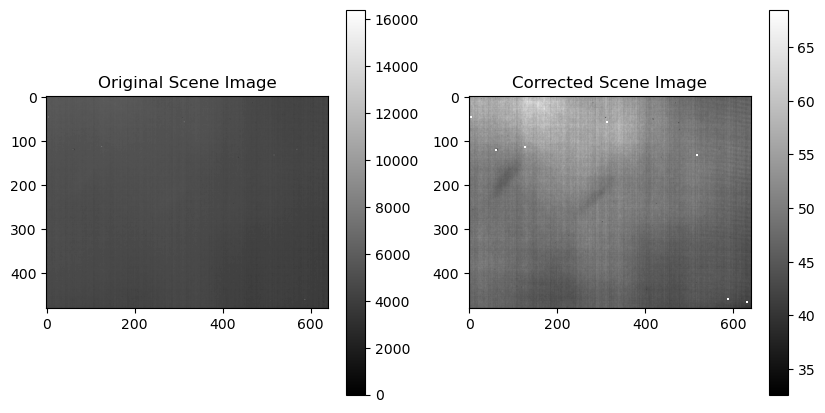

In [11]:
# Display original and corrected images for comparison
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_images[index], cmap='gray')
plt.colorbar()

# Corrected scene image
plt.subplot(1, 2, 2)
plt.title("Corrected Scene Image")
plt.imshow(corrected_scene_images[index], cmap='gray')
plt.colorbar()

plt.show()

####  Linear regression to calculate gain and offset for each pixel

In [12]:
from sklearn.linear_model import LinearRegression

# Extract calibration images and their corresponding temperatures
calibration_images = np.stack(calibration_df['image'].values)
temperatures = calibration_df['t_fpa'].values  # Example: FPA temperature in degrees Celsius

# Get the dimensions of the images
num_images, height, width = calibration_images.shape

# Reshape the data for regression
pixels = calibration_images.reshape(num_images, -1).T  # Shape: (num_pixels, num_images)

# Initialize arrays for gain and offset
gain = np.zeros((height, width))
offset = np.zeros((height, width))

# Perform linear regression for each pixel
for i in range(pixels.shape[0]):
    y = pixels[i, :]
    X = temperatures.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    gain.flat[i] = reg.coef_[0]
    offset.flat[i] = reg.intercept_

# Reshape gain and offset back to image dimensions
gain = gain.reshape(height, width)
offset = offset.reshape(height, width)

In [13]:
# Apply the correction to each scene image
scene_images = np.stack(scene_df['image'].values)
linear_reg_scene_images = np.array([apply_gain_offset_correction(img, gain, offset) for img in scene_images])

/var/folders/54/hy0k25rj3qq6wl3dn1jrwph00000gq/T/ipykernel_33279/919441850.py:3: RuntimeWarning: invalid value encountered in divide
  return (image - offset) / gain


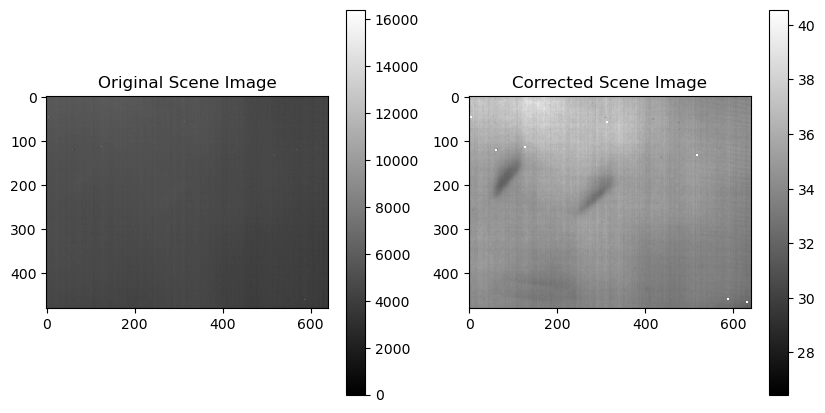

In [14]:
# Display original and corrected images for comparison
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_images[index], cmap='gray')
plt.colorbar()

# Corrected scene image
plt.subplot(1, 2, 2)
plt.title("Corrected Scene Image")
plt.imshow(linear_reg_scene_images[index], cmap='gray')
plt.colorbar()

plt.show()

#### Polynomial Regression -- not working

In [26]:
from sklearn.preprocessing import PolynomialFeatures

# Extract calibration images and their corresponding temperatures
calibration_images = np.stack(calibration_df['image'].values)
temperatures = calibration_df['t_fpa'].values  # Example: FPA temperature in degrees Celsius

# Get the dimensions of the images
num_images, height, width = calibration_images.shape

# Reshape the data for regression
pixels = calibration_images.reshape(num_images, -1).T  # Shape: (num_pixels, num_images)

# Define the degree of the polynomial
degree = 3  # Adjust degree as needed

# Initialize arrays for polynomial coefficients
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(temperatures.reshape(-1, 1))

# Initialize arrays for storing polynomial coefficients
coefficients = np.zeros((pixels.shape[0], X_poly.shape[1]))

# Fit a polynomial model for each pixel
for i in range(pixels.shape[0]):
    y = pixels[i, :]
    reg = LinearRegression().fit(X_poly, y)
    coefficients[i, :] = reg.coef_

# Reshape coefficients back to image dimensions
coefficients = coefficients.reshape(height, width, -1)

In [27]:
# Function to apply polynomial correction
def apply_polynomial_correction(image, coefficients, poly, temp):
    height, width = image.shape
    X_poly = poly.transform(np.array([[temp]]))  # Polynomial features for the given temperature
    corrected_image = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            pixel_poly_coeffs = coefficients[i, j]
            # Evaluate polynomial at the given temperature
            expected_value = np.dot(pixel_poly_coeffs, X_poly.T)
            corrected_image[i, j] = image[i, j] - expected_value
    return corrected_image

# Apply the correction to each scene image
scene_images = np.stack(scene_df['image'].values)
corrected_scene_images = np.array([apply_polynomial_correction(img, coefficients, poly, temp) for img, temp in zip(scene_images, scene_df['t_fpa'])])

/var/folders/54/hy0k25rj3qq6wl3dn1jrwph00000gq/T/ipykernel_33279/1548880028.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corrected_image[i, j] = image[i, j] - expected_value
/var/folders/54/hy0k25rj3qq6wl3dn1jrwph00000gq/T/ipykernel_33279/1548880028.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corrected_image[i, j] = image[i, j] - expected_value
/var/folders/54/hy0k25rj3qq6wl3dn1jrwph00000gq/T/ipykernel_33279/1548880028.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (De

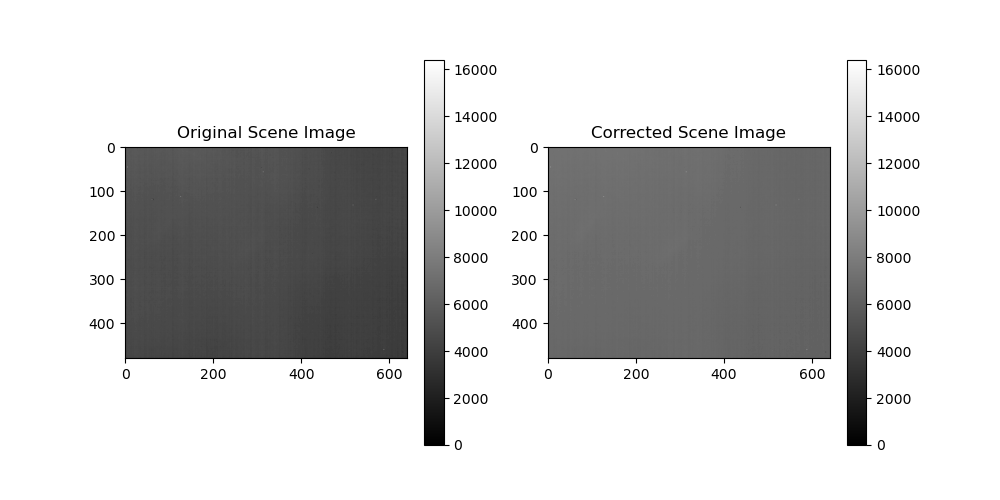

In [29]:
# Display original and corrected images for comparison
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_images[index], cmap='gray')
plt.colorbar()

# Corrected scene image
plt.subplot(1, 2, 2)
plt.title("Corrected Scene Image")
plt.imshow(corrected_scene_images[index], cmap='gray')
plt.colorbar()

plt.show()

KeyboardInterrupt: 

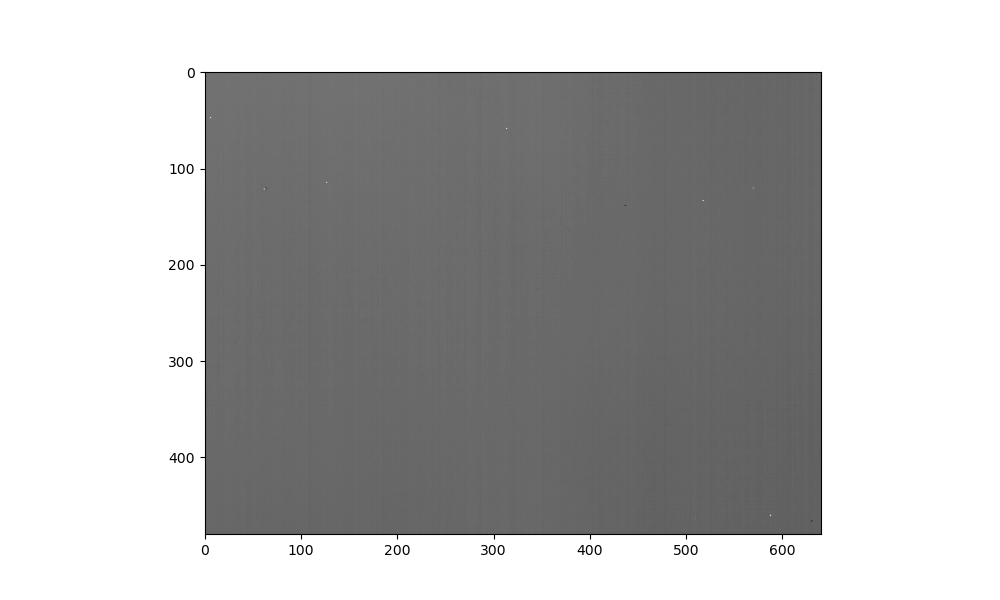

In [28]:
from IPython.display import display, clear_output
import time

# Function to display images in a loop
def display_images(images, interval=0.05):
    plt.figure(figsize=(10, 6))
    for img in images:
        plt.imshow(img, cmap='gray')
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(interval)

# Display the corrected images
display_images(corrected_scene_images)